In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
df = pd.read_csv('admin2.csv')
df.drop('Comments', axis=1, inplace=True)

In [4]:
df.head()

,id,text,label
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,racism
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,normal
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism
3,7792,"Finally I'm all caught up, and that sudden dea...",normal
4,7793,@carolinesinders @herecomesfran *hugs*,normal


In [5]:
df.fillna(value = df.mode().iloc[0] ,inplace =True)
print("No of missing values:")
print(df.isna().sum())

No of missing values:
id       0
text     0
label    0
dtype: int64


In [6]:
# Tokenize the text data
max_words = 1000  # Max number of words to consider as features
max_len = 100  # Max length of a sequence
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(df['text'].values)
sequences = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(sequences, maxlen=max_len)

In [7]:
# Stopword removal
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

In [8]:
# labels to categorical
label_dict = {'racism': 0, 'sexism': 1, 'toxic': 2, 'normal': 3}
df['types'] = df['label'].map(label_dict)

df = df.drop(['label'], axis=1)

df

,id,text,types
0,7789,@ AAlwuhaib1977 Muslim mob violence Hindus Ban...,0
1,7790,@ Te4m_NiGhtM4Re http : //t.co/5Ih7MkDbQG,3
2,7791,@ jncatron @ isra_jourisra @ AMPalestine Islam...,0
3,7792,"Finally 'm caught , sudden death cook looks li...",3
4,7793,@ carolinesinders @ herecomesfran * hugs *,3
...,...,...,...
4050,11859,"`` Shut , stupid . said NONE do.\n\nThen said ...",2
4051,11860,"`` 're stuff nightmares , moron ''",2
4052,11861,`` FUCKED WHITE MOM GGG . KNOW STANDS GERMAN G...,2
4053,11862,`` hat white point ? hide face ! n't need lear...,2


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['types'],test_size = 0.2)

In [10]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(sequences_train, maxlen=max_len)
X_test_padded = pad_sequences(sequences_test, maxlen=max_len)

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)

In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
# # LSTM
emb_dim = 128
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length=max_len))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(32, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
epochs = 15
batch_size = 32
result = model.fit(X_train_padded, y_train_one_hot, epochs=epochs, batch_size=batch_size,
                   validation_data=(X_test_padded, y_test_one_hot), callbacks=[early_stopping])

Epoch 1/15
102/102 [==============================] - 11s 73ms/step - loss: 1.5848 - accuracy: 0.3147 - val_loss: 1.4656 - val_accuracy: 0.4760
Epoch 2/15
102/102 [==============================] - 8s 75ms/step - loss: 1.2908 - accuracy: 0.4766 - val_loss: 1.0190 - val_accuracy: 0.6584
Epoch 3/15
102/102 [==============================] - 8s 74ms/step - loss: 1.0052 - accuracy: 0.6125 - val_loss: 0.8086 - val_accuracy: 0.6880
Epoch 4/15
102/102 [==============================] - 7s 70ms/step - loss: 0.8858 - accuracy: 0.6600 - val_loss: 0.7370 - val_accuracy: 0.7139
Epoch 5/15
102/102 [==============================] - 8s 75ms/step - loss: 0.8128 - accuracy: 0.7050 - val_loss: 0.6990 - val_accuracy: 0.7349
Epoch 6/15
102/102 [==============================] - 8s 75ms/step - loss: 0.7604 - accuracy: 0.7195 - val_loss: 0.6835 - val_accuracy: 0.7361
Epoch 7/15
102/102 [==============================] - 7s 70ms/step - loss: 0.7403 - accuracy: 0.7278 - val_loss: 0.6764 - val_accuracy: 0.743

In [18]:
evaluation_results = model.evaluate(X_train_padded, y_train_one_hot)
total_accuracy = evaluation_results[model.metrics_names.index('accuracy')]

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')

102/102 [==============================] - 1s 10ms/step - loss: 0.5222 - accuracy: 0.8335
Total Accuracy: 83.35%


26/26 [==============================] - 1s 9ms/step


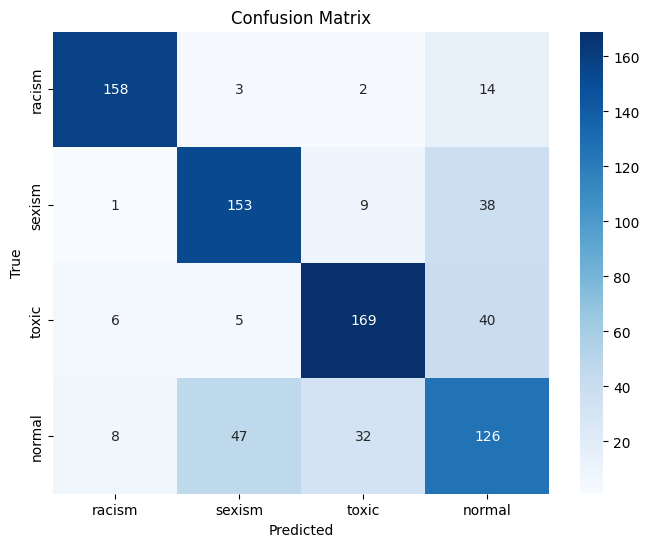

In [19]:
# Confusion matrix
y_pred = model.predict(X_test_padded)
y_pred_labels = label_binarizer.inverse_transform(y_pred)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

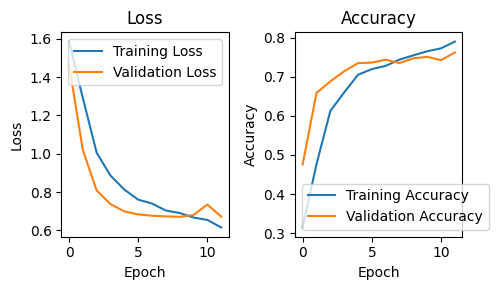

In [27]:
# Plotting loss and accuracy
plt.figure(figsize=(5, 3))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Precision: 0.7497
Recall: 0.7472
F1-score: 0.7483
